# UNet with Resnet 50 Backbone

Train Dataset Size: 

Val Dataset Size: 

Test Dataset Size:

In [1]:
# %pip install torch -q
# %pip install opencv-python -q
# %pip install pycocotools -q
# %pip install timm==0.6.12 -q
# %pip install ipdb -q

In [1]:
from backbones_unet.model.unet import Unet
from backbones_unet.utils.dataset import SemanticSegmentationDataset
from backbones_unet.model.losses import DiceLoss
from backbones_unet.utils.trainer import Trainer
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from convert_coco_ann_to_mask import convert_coco_to_mask
from torchvision.datasets import ImageFolder

import torchvision
import torch
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

/home/atharva/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# Test Installation
random_tensor = torch.rand((1, 3, 64, 64))
model = Unet(in_channels=3, num_classes=1) # if no backbone specified, will default to Resnet50
print(model.predict(random_tensor))
# summary(model, random_tensor)

tensor([[[[ 0.0486,  0.7246,  1.0668,  ...,  0.7348, -0.3890,  1.4802],
          [-0.0175,  0.9410,  1.2087,  ...,  0.6050,  0.7908,  1.6351],
          [ 0.3561,  1.3139,  2.0573,  ...,  0.8333,  0.9665,  1.2262],
          ...,
          [ 1.6275,  0.5018,  0.3685,  ...,  0.3771,  0.2761,  0.4152],
          [ 1.4081,  0.6855,  0.4278,  ...,  0.3785,  0.1780, -0.0518],
          [-0.9059,  0.6601, -0.9113,  ...,  1.3791,  0.5637, -0.2057]]]])


In [3]:
# Feel free to add more items here
config = {
    "lr"         : 1e-4,
    "epochs"     : 100,
    "batch_size" : 1,  # Increase if your device can handle it
    "num_classes": 1,
    'truncated_normal_mean' : 0,
    'truncated_normal_std' : 0.2,
}

In [4]:
# create a torch.utils.data.Dataset/DataLoader
annotation_json_path = '//home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/data/rosbags_collated/round_1/annotations.json'
train_img_path = '/home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/data/rosbags_collated/round_1'
train_mask_path = '/home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/data/rosbags_collated/round_1/masks-clean'

train_img_path_for_ImageFolder_dataloader = '/home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/data/rosbags_collated/round_1/images-clean'

#! Temporarily using train and val images as same
val_img_path = '/home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/data/rosbags_collated/round_1/images-clean'
val_mask_path = '/home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/data/rosbags_collated/round_1/masks-clean'

test_img_path = '/home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/data/rosbags_collated/round_1/masks-clean'

# img_size = (1384, 1032) # = width, height            # currently PtGrey images
img_size = (1024, 1024)

## Extract Masks from the COCO annotations (if not already done)

In [5]:
# convert_coco_to_mask(input_json=annotation_json_path, image_folder=train_img_path, output_folder=train_mask_path)

TypeError: convert_coco_to_mask() got an unexpected keyword argument 'output_folder'

In [6]:
# Find mean and std of your dataset:
def get_mean_and_std_calculated(IMAGE_DATA_DIR):
    """
    NOTE: The ImageFolder dataloader requires the following file structure:

    root
    |
    └── cat (class label)
        |
        ├──img_2.png
        └──img_1.png

    """
    train_dataset = ImageFolder(IMAGE_DATA_DIR, transform=torchvision.transforms.ToTensor())

    # Initialize lists to store channel-wise means and standard deviations
    channel_wise_means = [0.0, 0.0, 0.0]
    channel_wise_stds = [0.0, 0.0, 0.0]

    # Iterate through the training dataset to calculate means and standard deviations
    for image, _ in train_dataset:
        for i in range(3):  # Assuming RGB images
            channel_wise_means[i] += image[i, :, :].mean().item()
            channel_wise_stds[i] += image[i, :, :].std().item()

    # Calculate the mean and standard deviation for each channel
    num_samples = len(train_dataset)
    channel_wise_means = [mean / num_samples for mean in channel_wise_means]
    channel_wise_stds = [std / num_samples for std in channel_wise_stds]

    # Print the mean and standard deviation for each channel
    print("Mean:", channel_wise_means)
    print("Std:", channel_wise_stds)

    return channel_wise_means, channel_wise_stds

# means, stds = get_mean_and_std_calculated(train_img_path_for_ImageFolder_dataloader)
means = [0.44895144719250346, 0.4951483853617493, 0.4498602793532975]
stds = [0.21388493326245522, 0.24571933703763144, 0.22413276759337405]

normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=means, std=stds) # always normalize only after tensor conversion
    ])

In [7]:
train_transforms = torchvision.transforms.Compose([
    # To PIL Image
    # torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.ColorJitter(brightness=0.16, contrast=0.15, saturation=0.1),
    torchvision.transforms.RandomRotation(18),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    torchvision.transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    torchvision.transforms.ToTensor(),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = SemanticSegmentationDataset(img_paths=train_img_path, mask_paths=train_mask_path, size=img_size, mode='binary', normalize=normalize_transform, transformations=train_transforms)
val_dataset = SemanticSegmentationDataset(img_paths=val_img_path, mask_paths=val_mask_path, size=img_size, mode='binary', normalize=normalize_transform, transformations=val_transforms)
test_dataset = SemanticSegmentationDataset(img_paths=val_img_path, mask_paths=None, size=img_size, normalize=normalize_transform, transformations=test_transforms)

temp = train_dataset.__getitem__(1)

# Create data loaders
train_loader = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True
)

val_loader = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

test_loader = DataLoader(
    dataset     = test_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    drop_last   = False,
    num_workers = 2)

In [8]:
model = Unet(
    # backbone='convnext_base', # backbone network name
    backbone='resnet50',
    preprocessing=True,
    in_channels=3, # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=config["num_classes"],  # output channels (number of classes in your dataset)
    encoder_freeze=True,
    pretrained=True,
)

# model = model().to(device)
random_tensor = torch.rand((1, 3, 1024, 1024))
print(model.predict(random_tensor))

tensor([[[[-0.1804, -0.4127, -0.8712,  ..., -0.1222,  0.5645,  0.3687],
          [-1.0355, -0.1917, -0.1325,  ...,  1.4944,  1.2830,  1.8483],
          [-1.3203,  0.5161,  0.3228,  ..., -0.0679,  0.2115,  1.6003],
          ...,
          [-2.4057, -0.1900,  1.2223,  ..., -0.2408, -0.5964,  0.8715],
          [-1.1483, -0.9154,  0.7726,  ..., -0.3753, -1.0234, -1.0090],
          [-0.6254,  0.1632,  0.6146,  ..., -0.3406,  1.4562, -0.3611]]]])


In [9]:
# Define wandb credentials

import wandb
wandb.login(key="1ac5a5f7d94024d9db15fd8d11cdffe1ebd1e89e") #API Key is in your wandb account, under settings (wandb.ai/settings)

run = wandb.init(
    name = "UNet_with_resnet_50", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "IDL_Project_Segmentation", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: atharvapusalkar18 (bayesian_mind). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/atharva/.netrc


In [10]:
checkpoint_path = '/home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/models/checkpoint.pth'

In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=config['lr'], betas=(0.9, 0.999), weight_decay=0.05)
gamma = 0.8
milestones = [10,20,40,60,80]

# scheduler1 = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.9, total_iters=5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
# scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2, scheduler3], milestones=[20, 51])

mixed_precision_scaler = torch.cuda.amp.GradScaler()

trainer = Trainer(
    model=model,              # UNet model with Resnet50 backbone
    criterion=DiceLoss(),     # loss function
    optimizer=optimizer,
    epochs=10,
    # scaler=mixed_precision_scaler,
    lr_scheduler=scheduler,
    device=device,
    checkpoint_path=checkpoint_path
)

trainer.fit(train_loader, val_loader)

Validation: 100%|██████████| 536/536 [00:14<00:00, 38.24 validating-batch/s, loss=0.307]


Val Loss 0.3269
Saving model


Validation: 100%|██████████| 536/536 [00:14<00:00, 37.83 validating-batch/s, loss=0.286]


Val Loss 0.3021
Saving model


Validation: 100%|██████████| 536/536 [00:14<00:00, 38.04 validating-batch/s, loss=0.266]


Val Loss 0.2773
Saving model


Validation: 100%|██████████| 536/536 [00:14<00:00, 37.00 validating-batch/s, loss=0.244]


Val Loss 0.2640
Saving model


Traning Model on 10 epochs:  50%|█████     | 5/10 [03:14<03:14, 38.82s/it]

Val Loss 0.2702


Validation: 100%|██████████| 536/536 [00:14<00:00, 37.07 validating-batch/s, loss=0.23]


Val Loss 0.2436
Saving model


Validation: 100%|██████████| 536/536 [00:14<00:00, 37.61 validating-batch/s, loss=0.227]


Val Loss 0.2336
Saving model


Traning Model on 10 epochs:  80%|████████  | 8/10 [05:11<01:17, 38.87s/it]

Val Loss 0.2384


Validation: 100%|██████████| 536/536 [00:13<00:00, 38.90 validating-batch/s, loss=0.199]


Val Loss 0.2237
Saving model


Traning Model on 10 epochs: 100%|██████████| 10/10 [06:28<00:00, 38.87s/it]


Val Loss 0.2432


In [14]:
# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
    # If the checkpoint file exists, load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']  # last epoch
    val_loss = checkpoint['val_loss']  # Update the best accuracy
    # Load the checkpoint and update the scheduler state if it exists in the checkpoint
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Loaded scheduler state from checkpoint.")
    else:
        print("No scheduler state found in checkpoint.")
    print("Loaded checkpoint from:", checkpoint_path)
else:
    # If the checkpoint file does not exist, start training from scratch
    start_epoch = 0
    print("No checkpoint found at:", checkpoint_path)

print(model)

Loaded scheduler state from checkpoint.
Loaded checkpoint from: /home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/sensors_2023-08-03-15-19-03_0/models/checkpoint.pth
Unet(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Iden

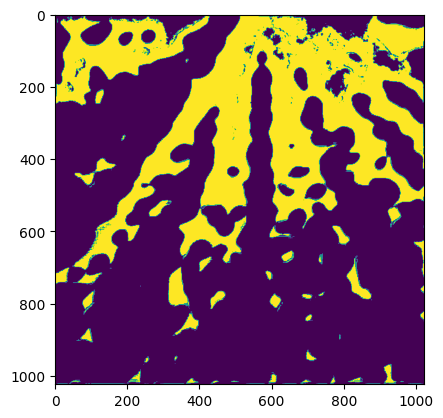

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Test the model
model.eval()

TEST_IMG_PATH = '/home/atharva/Documents/Courses/11-785/Project/pretrained-backbones-unet/sensors_2023-08-03-15-19-03_0/images/frame000000.png'

test_img = cv2.imread(TEST_IMG_PATH)

test_img = cv2.resize(test_img, (1024, 1024))

test_img = test_transforms(test_img)

test_img = test_img.unsqueeze(0)

test_img = test_img.to(device)

with torch.no_grad():
    pred = model.predict(test_img)

pred = pred.squeeze(0)

pred = pred.squeeze(0)

pred = pred.cpu().numpy()

pred = np.where(pred > 0.5, 1, 0)

pred = pred.astype(np.uint8)

plt.imshow(pred)
